In [1]:
import os
import pickle
from scipy import signal
import libfmp.b
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks, peak_prominences
from pydub.generators import Triangle

from compute_tempo import *
from mutils import DataHandler
from dance_evaluation import *

In [ ]:
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]

filename = mvnfiles[1]
piece_name = os.path.basename(filename).split(".")[0]
data_handler = DataHandler()
motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)

sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_FOOT"]
    
sensorA_velocity_norm = z_score_normalize(sensorA_velocity)
sensorA_vel_xyz = calc_xyz(sensorA_velocity_norm)

sensor_abs_vel = smooth_velocity(sensorA_vel_xyz, abs="no", window_length = 120, polyorder = 0)
sensorA_velocity_ax = sensor_abs_vel[start_f:end_f]


# Find peaks and their properties
peaks_temp, properties = find_peaks(sensorA_velocity_ax.flatten(), height=0.02, distance=60)
peak_values = sensorA_velocity_ax[peaks_temp]
h_cutoff = np.percentile(peak_values, 20)
print(h_cutoff)
# Apply the prominence threshold
final_peaks, final_properties = find_peaks(sensorA_velocity_ax.flatten(), height=h_cutoff, prominence= 0.3)
peak_onset = np.zeros(len(sensorA_velocity_ax))
peak_onset[final_peaks] = 1

# peak_onset = get_peak_onsets(sensor_abs_vel[start_f:end_f])


plt.figure(figsize=(20,5))
plt.plot(sensorA_velocity_ax)
plt.plot(peak_onset, linewidth=1, color = 'r')

### One Sensor

Loaded BKO_E1_D1_08_Suku_T.pkl
Error encountered for: Group 'gr' not found in the dataset.
Loaded BKO_E3_D5_03_Wasulunka_T.pkl
Total Sections: 1
tempo_A: 82.2
tempo_B: 82.2
reference_bpm: 114.2032818416782


[ 70.  56.  94.  74. 117.]
[ 70.  56.  94.  74. 117.]


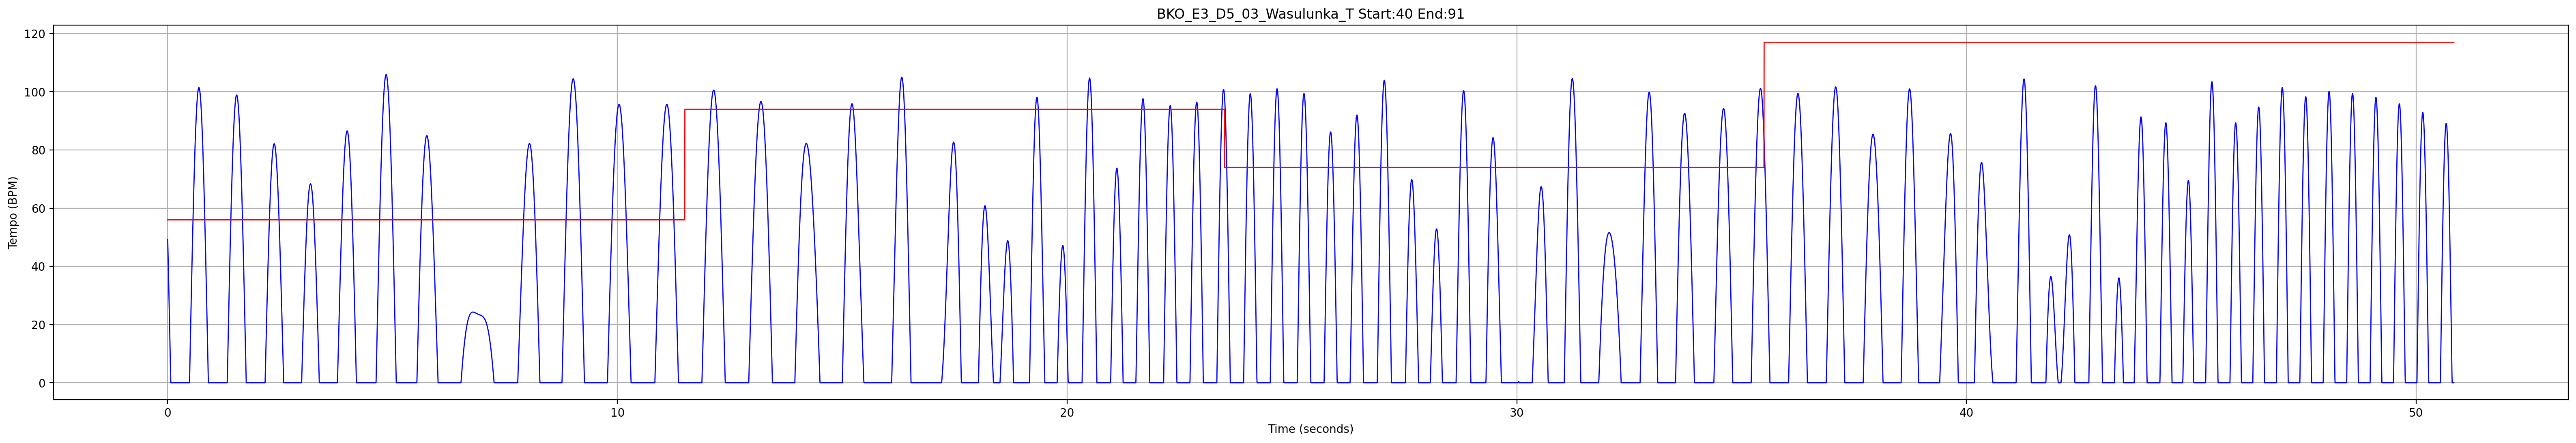

Loaded BKO_E2_D4_05_Sandia_T.pkl
Total Sections: 1
tempo_A: 83.2
tempo_B: 83.2
reference_bpm: 91.98453195432808


[68. 67. 93. 93. 95.]
[68. 67. 93. 93. 95.]


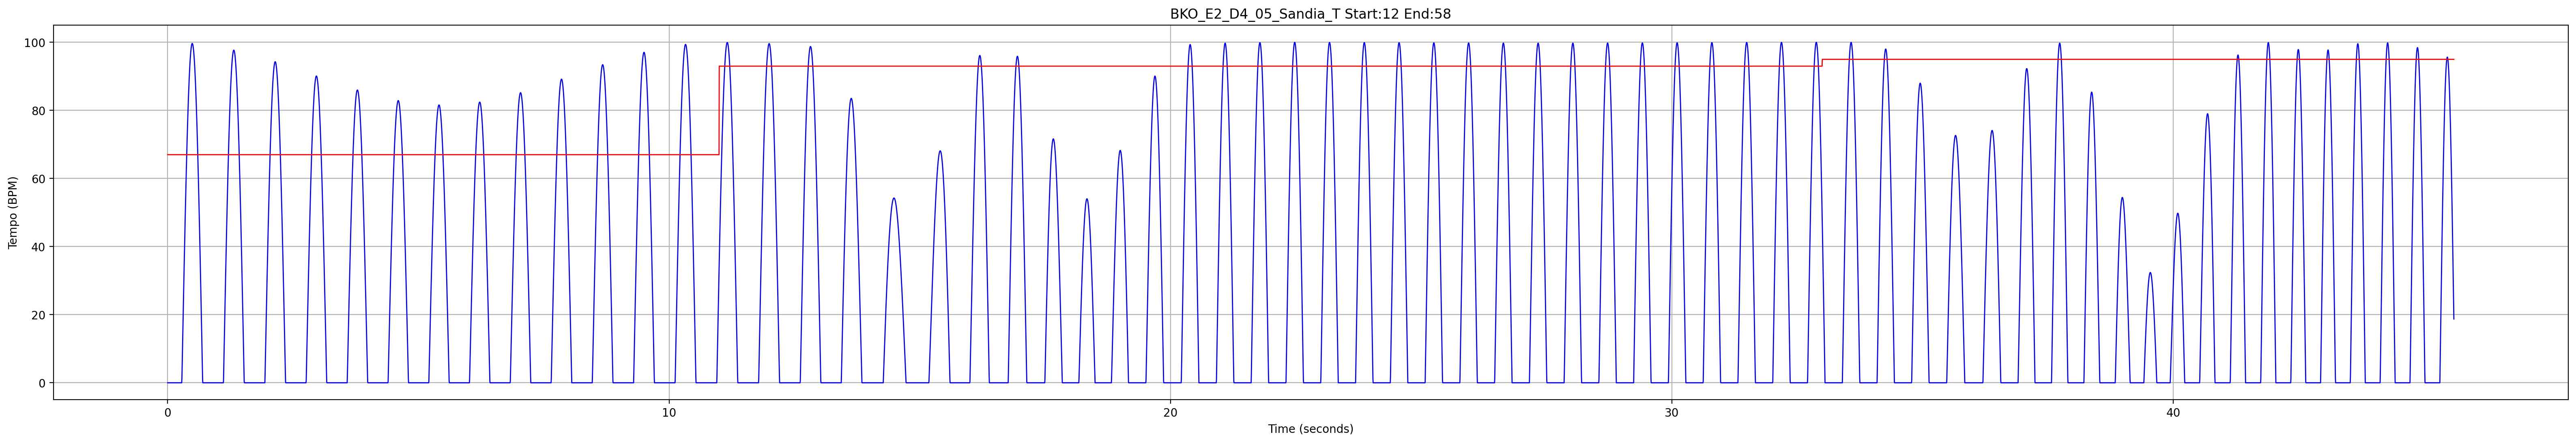

Loaded BKO_E2_D4_01_Suku_T.pkl
Total Sections: 1
tempo_A: 64.0
tempo_B: 64.0
reference_bpm: 128.83789500673035


[64. 64. 65. 64. 63.]
[64. 64. 65. 64. 63.]


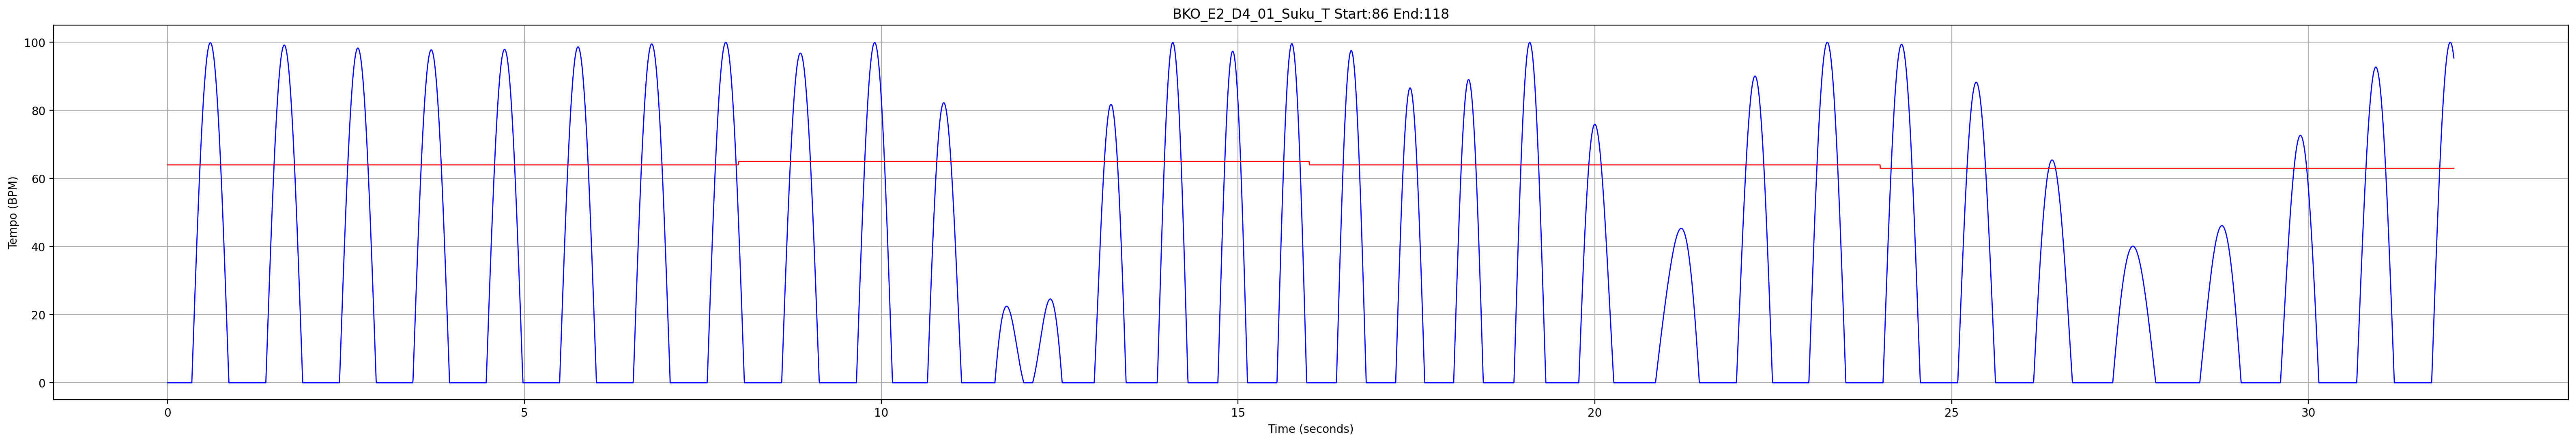

In [2]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT
pkl_filelist = os.listdir(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/Dataset_V2")
data_handler = DataHandler()
result = {
    "piece": [],
    "bpm_gt": [],
    "tempoA": [],
    "tempoB": [],
}

for idx, filename in enumerate(pkl_filelist):

    filename = filename.replace("_Dancers.csv", "_T.mvnx")
    piece_name = os.path.basename(filename).split(".")[0]
    try:
        motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)
    except ValueError as e:
        # Handle the error and continue
        print(f"Error encountered for: {e}")
        continue
    
    
    duration = int(end_t-start_t)
    w_sec = int(duration/2)
    h_sec = int(w_sec/2)
    
    mocap_fps = 240
    window_size = int(240*w_sec)
    hop_size = int(240*h_sec)
    tempi_range = np.arange(50,150,1)

    sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_HAND"][start_f:end_f, :]
    
    sensorA_velocity_norm = z_score_normalize(sensorA_velocity)
    sensorA_vel_xyz = calc_xyz(sensorA_velocity_norm)
    sensor_abs_vel = smooth_velocity(sensorA_vel_xyz, abs="no", window_length = 100, polyorder = 0)

    novelty_length = len(sensorA_velocity)
    time_axis = np.arange(novelty_length)/mocap_fps

    tempo_json = main_1S_xyz(sensorA_vel_xyz, mocap_fps, window_size, 
                             hop_size, tempi_range)

    sensor_abs_vel = tempo_json["sensor_abs_vel"]
    # sensor_dir_onsets = tempo_json["sensor_dir_change_onsets"]
    # sensor_dir_onsets_f = tempo_json["sensor_dir_change_onsets_f"]
    # sensor_onsets = tempo_json["sensor_onsets"]

    # tempogram_ab = tempo_json["tempogram_ab"]
    # time_axis_seconds = tempo_json["time_axis_seconds"]
    # tempo_axis_bpm = tempo_json["tempo_axis_bpm"]

    tempo_data_maxmethod = tempo_json["tempo_data_maxmethod"]
    tempo_data_weightedkernel = tempo_json["tempo_data_weightedkernel"]

    # Max method
    Aestimated_beat_pulse = tempo_data_maxmethod["estimated_beat_pulse"]
    Atempo_curve = tempo_data_maxmethod["tempo_curve"]
    bpmA_arr = tempo_data_maxmethod["bpm_arr"]
    # Atempo_curve_time_axis = tempo_data_maxmethod["tempo_curve_time_axis"]
    # Aglobal_tempo_bpm = tempo_data_maxmethod["global_tempo_bpm"]

    # Weighted method
    Bestimated_beat_pulse = tempo_data_weightedkernel["estimated_beat_pulse"]
    Btempo_curve = tempo_data_weightedkernel["tempo_curve"]
    bpmB_arr = tempo_data_weightedkernel["bpm_arr"]
    # Btempo_curve_time_axis = tempo_data_weightedkernel["tempo_curve_time_axis"]
    # Bglobal_tempo_bpm = tempo_data_weightedkernel["global_tempo_bpm"]

    # dance_onset, estimated_beat_onset, drum_ref, dance_onset_iois, estimated_beats_iois = data_handler.onsets_for_plotting(sensor_onsets, Aestimated_beat_pulse, novelty_length)
    # dance_bpm = data_handler.calc_tempo_from_onsets(dance_onset)

    tempo_A = np.average(bpmA_arr)  # Average over the desired frame range
    tempo_B = np.average(bpmB_arr)

    result["piece"].append(piece_name)
    result["bpm_gt"].append(np.round(bpm,2))
    result["tempoA"].append(np.round(tempo_A,2))
    result["tempoB"].append(np.round(tempo_B,2))
    
    print("tempo_A:", np.average(tempo_A)    # [start_f:end_f]
    print("tempo_B:", np.average(tempo_B)
    print("reference_bpm:", bpm)
    print("\n")
    print(tempo_data_maxmethod["bpm_arr"])
    print(tempo_data_weightedkernel["bpm_arr"])

    plt.figure(figsize=(40, 6), dpi=200)
    plt.plot(time_axis,100*Aestimated_beat_pulse, linewidth=1, color = 'b')
    plt.plot(time_axis, Atempo_curve, linewidth=1, color = 'r')             # [start_f:end_f]
    # plt.plot(100*sensor_onsets.flatten(), linewidth=1, color = 'r')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Tempo (BPM)')
    plt.title(f'{piece_name} Start:{round(start_t)} End:{round(end_t)}')
    plt.grid(True)
    plt.show()
    
    
    if idx==3:
        break
    
# results_df = pd.DataFrame(result)
# csv_filename = f"./results/hand/xyz/hand_xyz_50_150.csv"
# results_df.to_csv(csv_filename, index=False)
# print(f"Results saved to {csv_filename}")

In [ ]:
tempo_data_maxmethod["bpm_arr"]

In [ ]:
np.average(tempo_data_maxmethod["bpm_arr"])

In [ ]:
plot_tempogram_perAxis(tempo_json, islog= 'no', dpi=100)
plt.figure(figsize=(40, 6), dpi=200)
plt.plot(100*Aestimated_beat_pulse[start_f:end_f], linewidth=1, color = 'b')
plt.plot(Atempo_curve[start_f:end_f], linewidth=1, color = 'r')

plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title(f'{piece_name} Start:{round(start_t)} End:{round(end_t)}')
plt.grid(True)
plt.show()

In [ ]:
# Per mode: drum onset and directional change onset plot

plt.figure(figsize=(40, 6), dpi=300)
window_size = 0.1
for onset in beat_ref:
    window_start = onset - (window_size/2)  # Start of the window
    window_end = onset + (window_size/2)   # End of the window
    
    plt.axvspan(window_start, window_end, color='r', alpha=0.3)     # shaded window
    plt.axvline(onset, color='red', linestyle='--', linewidth=0.9)  # onset as a vertical line

plt.vlines(x= dance_onset, ymin=0.0, ymax=1, color='g', linewidth=1,)
plt.xlabel('Time (seconds)')
plt.title(f'{piece_name}')
plt.grid(True)
plt.show()

In [ ]:
results = evaluate_dance_onsets_with_half_beats(beat_ref, dance_onset, tolerance=0.1)
print("\nEvaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")
print("-"*40)

In [ ]:
tt = np.linspace(0, len(Atempo_curve)/240, len(Atempo_curve))

plt.figure(figsize=(40, 6), dpi=200)
# plt.plot(Aestimated_beat_pulse, linewidth=0.3, color = 'red')
plt.plot(Atempo_curve_time_axis, Ctempo_curve, linewidth=0.9, color = 'red')
plt.vlines(x=np.array([start_f/mocap_fps, end_f/mocap_fps]), ymin=0.0, ymax=180, color='g', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Beat Pulse')
plt.grid(True)
plt.show()

In [ ]:
time = np.arange(novelty_length) / mocap_fps
peaks, properties = signal.find_peaks(Aestimated_beat_pulse)  # , prominence=0.02
beat_peaks_sec = time[peaks]

In [ ]:
click_duration = 50  # milliseconds
click_freq = 1200  # Hz
file_name ="maraka"
# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = beat_peaks_sec  # kept_onsets/240   beat_peaks_sec
dN = novelty_length
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Both_Foot_new.wav"), format="wav")
# audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Bothhand_dir.wav"), format="wav")